  0%|                                                 | 0/96325 [00:00<?, ?it/s]

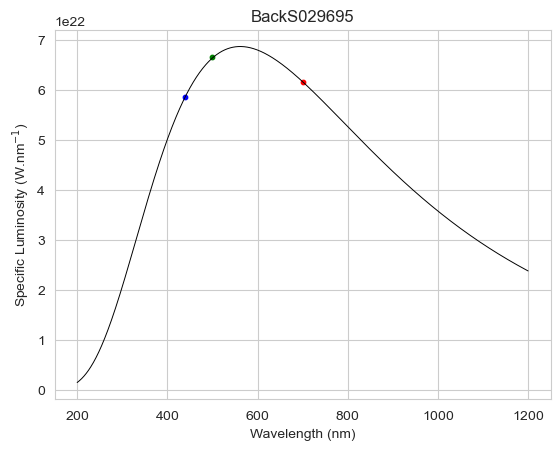

  0%|                                       | 1/96325 [00:00<4:04:20,  6.57it/s]

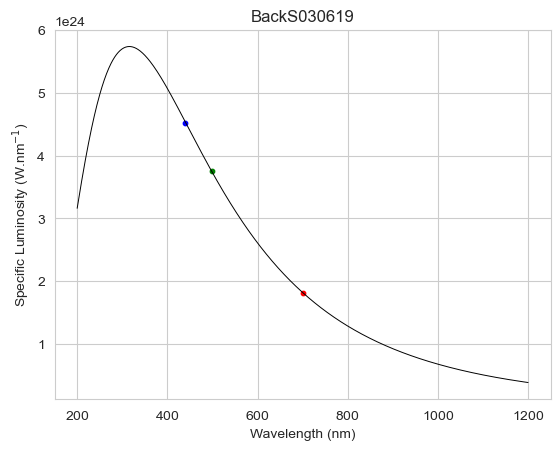

  0%|                                       | 2/96325 [00:00<3:50:12,  6.97it/s]

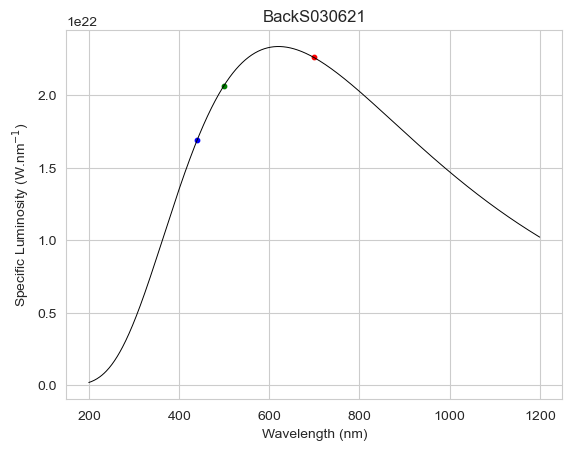

  0%|                                       | 3/96325 [00:00<3:43:25,  7.19it/s]

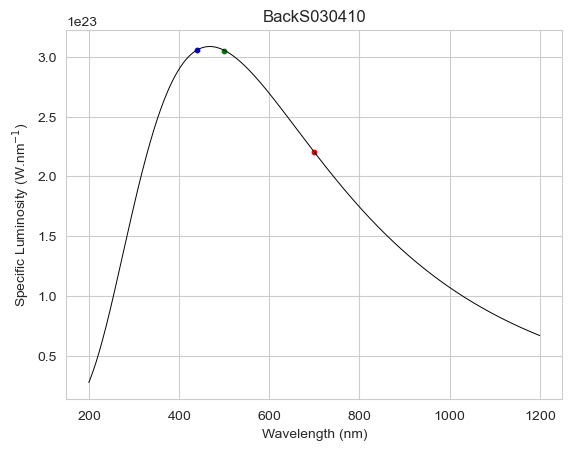

  0%|                                       | 4/96325 [00:00<3:45:01,  7.13it/s]

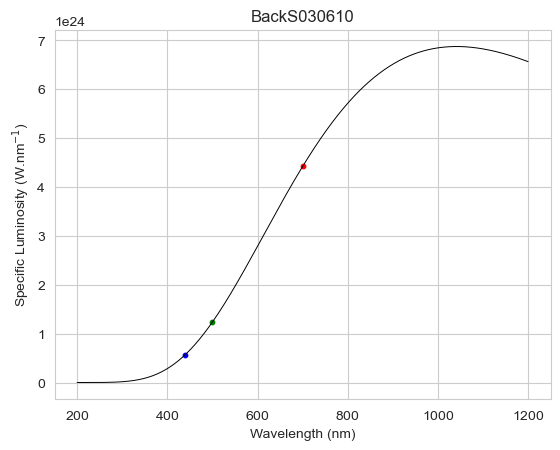

  0%|                                       | 5/96325 [00:00<3:44:03,  7.16it/s]

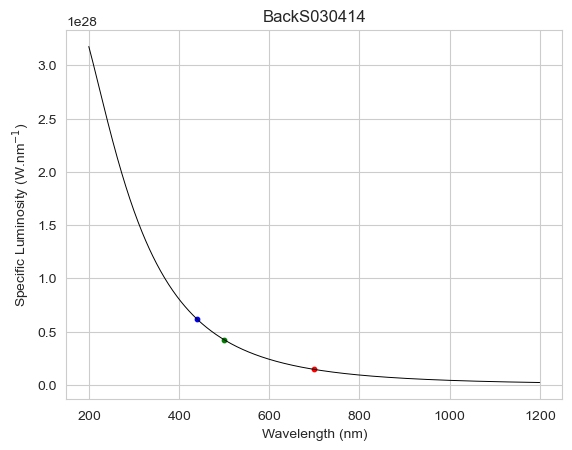

  0%|                                       | 6/96325 [00:00<4:43:21,  5.67it/s]

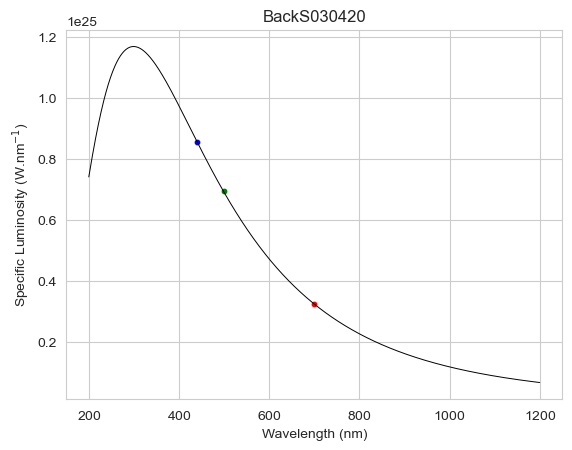

  0%|                                       | 7/96325 [00:01<4:20:58,  6.15it/s]

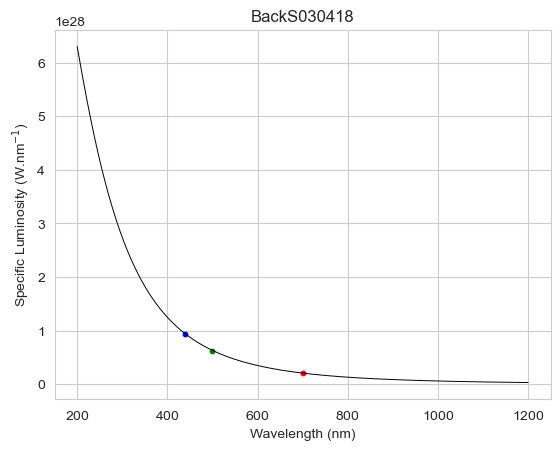

  0%|                                       | 8/96325 [00:01<4:10:17,  6.41it/s]

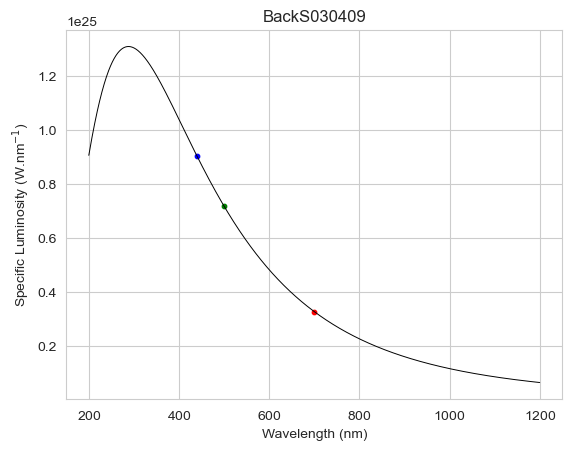

  0%|                                       | 9/96325 [00:01<3:57:57,  6.75it/s]

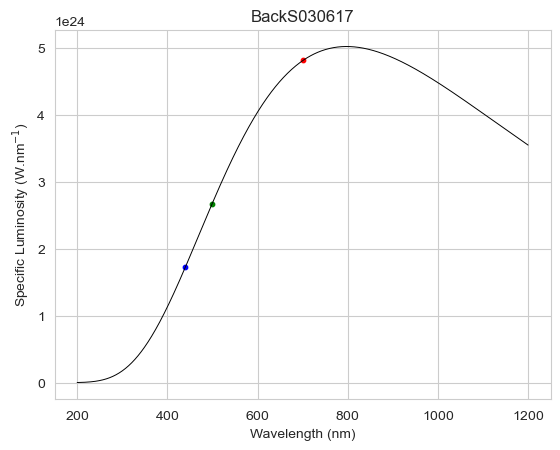

  1%|▏                                     | 518/96325 [00:01<02:00, 793.58it/s]/Users/kobibrown/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
  1%|▎                                     | 729/96325 [00:02<01:43, 923.30it/s]/var/folders/kv/ny8sb_xj09b1r7l0mtvkgjlm0000gn/T/ipykernel_82500/2048347049.py:25: RuntimeWarning: overflow encountered in exp
  funct = 2 * h * c**2 / x**5 / (np.exp(h * c / (x * k * T)) - 1) * a
/Users/kobibrown/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
  2%|▋                                   | 1685/96325 [00:03<01:31, 1035.65it/s]/Users/kobibrown/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: O

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
from tqdm import tqdm

# Load the data from the CSV file
star_data = pd.read_csv("/Users/kobibrown/Desktop/Distance_Ladder_Project/clustered_star_data_with_distances.csv")

# Add columns for uncertainties
for col in flux_cols:
    star_data[f"{col}_Uncertainty"] = 0.01 * star_data[col]

star_data["Parallax_Uncertainty"] = 0.001  # 0.001 arcseconds uncertainty in parallaxes

# Update flux_uncertainty_cols to include the new uncertainty columns
flux_uncertainty_cols = [f"{col}_Uncertainty" for col in flux_cols]

# planck function
def planck_func(x, T, a):
    h = 6.626e-34  # Planck's constant in m^2 kg / s
    c = 3e8        # Speed of light in m/s
    k = 1.38e-23   # Boltzmann's constant in m^2 kg / s^2 K
    funct = 2 * h * c**2 / x**5 / (np.exp(h * c / (x * k * T)) - 1) * a
    return funct

# pull data
wavelengths = np.array([440e-9, 500e-9, 700e-9])  # Wavelengths for blue, green, and red bands
flux_cols = ["BlueF", "GreenF", "RedF"]
fluxes = star_data[flux_cols].values
parallax = star_data["Parallax"].values

# simulate planck function
temperatures = []
temp_errs = []  # stop temp uncertainty
names = []
for i, flux_row in tqdm(enumerate(fluxes), total=len(fluxes)):
    # Use the calculated distance if it is over 200 parsecs, otherwise use parallax
    par = parallax[i]
    dist_parallax = 1 / par if par > 0 else np.nan
    dist_estimated = star_data.iloc[i]["Distance"]

    dist = dist_parallax if dist_parallax < 200 else dist_estimated

    multiplier = (dist * 3.086e16)**2  # approx luminosity
    specific_luminosity = flux_row * multiplier  # Specific Luminosity for each band
    specific_luminosity = specific_luminosity.astype(np.float64)  # Ensure the array is float64


    # Propagate flux and parallax uncertainties
    flux_uncertainty = star_data.iloc[i][flux_uncertainty_cols].values
    specific_luminosity_uncertainty = flux_uncertainty * multiplier
    specific_luminosity_uncertainty = specific_luminosity_uncertainty.astype(np.float64)  # Ensure the array is float64


    # Propagate parallax uncertainty to distance
    parallax_uncertainty = star_data.iloc[i]["Parallax_Uncertainty"]
    dist_uncertainty = np.abs(dist_parallax**2 * parallax_uncertainty) if dist_parallax < 200 else 0

    # Propagate distance uncertainty to specific luminosity
    if dist_uncertainty:
        specific_luminosity_uncertainty += 2 * dist * 3.086e16 * dist_uncertainty * flux_row

    try:
        star_props, cov = curve_fit(planck_func, wavelengths, specific_luminosity, sigma=specific_luminosity_uncertainty, p0=[10000, 1e10], absolute_sigma=True)
        star_temp, mult = star_props
        temp_err = np.sqrt(np.diag(cov))[0]  # find the uncertainty
        if star_temp > 2000 and star_temp < 150000:  # define realistic values
            temperatures.append(star_temp)
            temp_errs.append(temp_err)
            names.append(star_data.iloc[i]["Name"])
            if len(temperatures) <= 10:
                x = np.linspace(200e-9, 1200e-9, 1000)
                planck = planck_func(x, *star_props)
                plt.plot(x * 1e9, planck, c="k", linewidth=0.7)
                for j, flux in enumerate(flux_row):
                    plt.scatter(wavelengths[j] * 1e9, flux * multiplier, c=["b", "g", "r"][j], s=10)
                plt.xlabel("Wavelength (nm)")
                plt.ylabel("Specific Luminosity (W.nm$^{-1}$)")
                plt.ticklabel_format(axis="x", style="scientific", useMathText=True)
                plt.title(names[-1])
                plt.show()
    except RuntimeError:
        pass

# Convert the temperatures list to a NumPy array
temperatures_array = np.array(temperatures)
temp_errs_array = np.array(temp_errs)

# Add the temperature and temperature uncertainty columns to the star data
star_data['Temperature'] = np.nan
star_data['Temperature_Uncertainty'] = np.nan

# Fill in the temperature and temperature uncertainty values for each star
for i, name in enumerate(names):
    star_data.loc[star_data['Name'] == name, 'Temperature'] = temperatures_array[i]
    star_data.loc[star_data['Name'] == name, 'Temperature_Uncertainty'] = temp_errs_array[i]

# Save the updated star data to a new CSV file
star_data.to_csv('/Users/kobibrown/Desktop/Distance_Ladder_Project/star_data_with_temp_and_dist.csv', index=False)

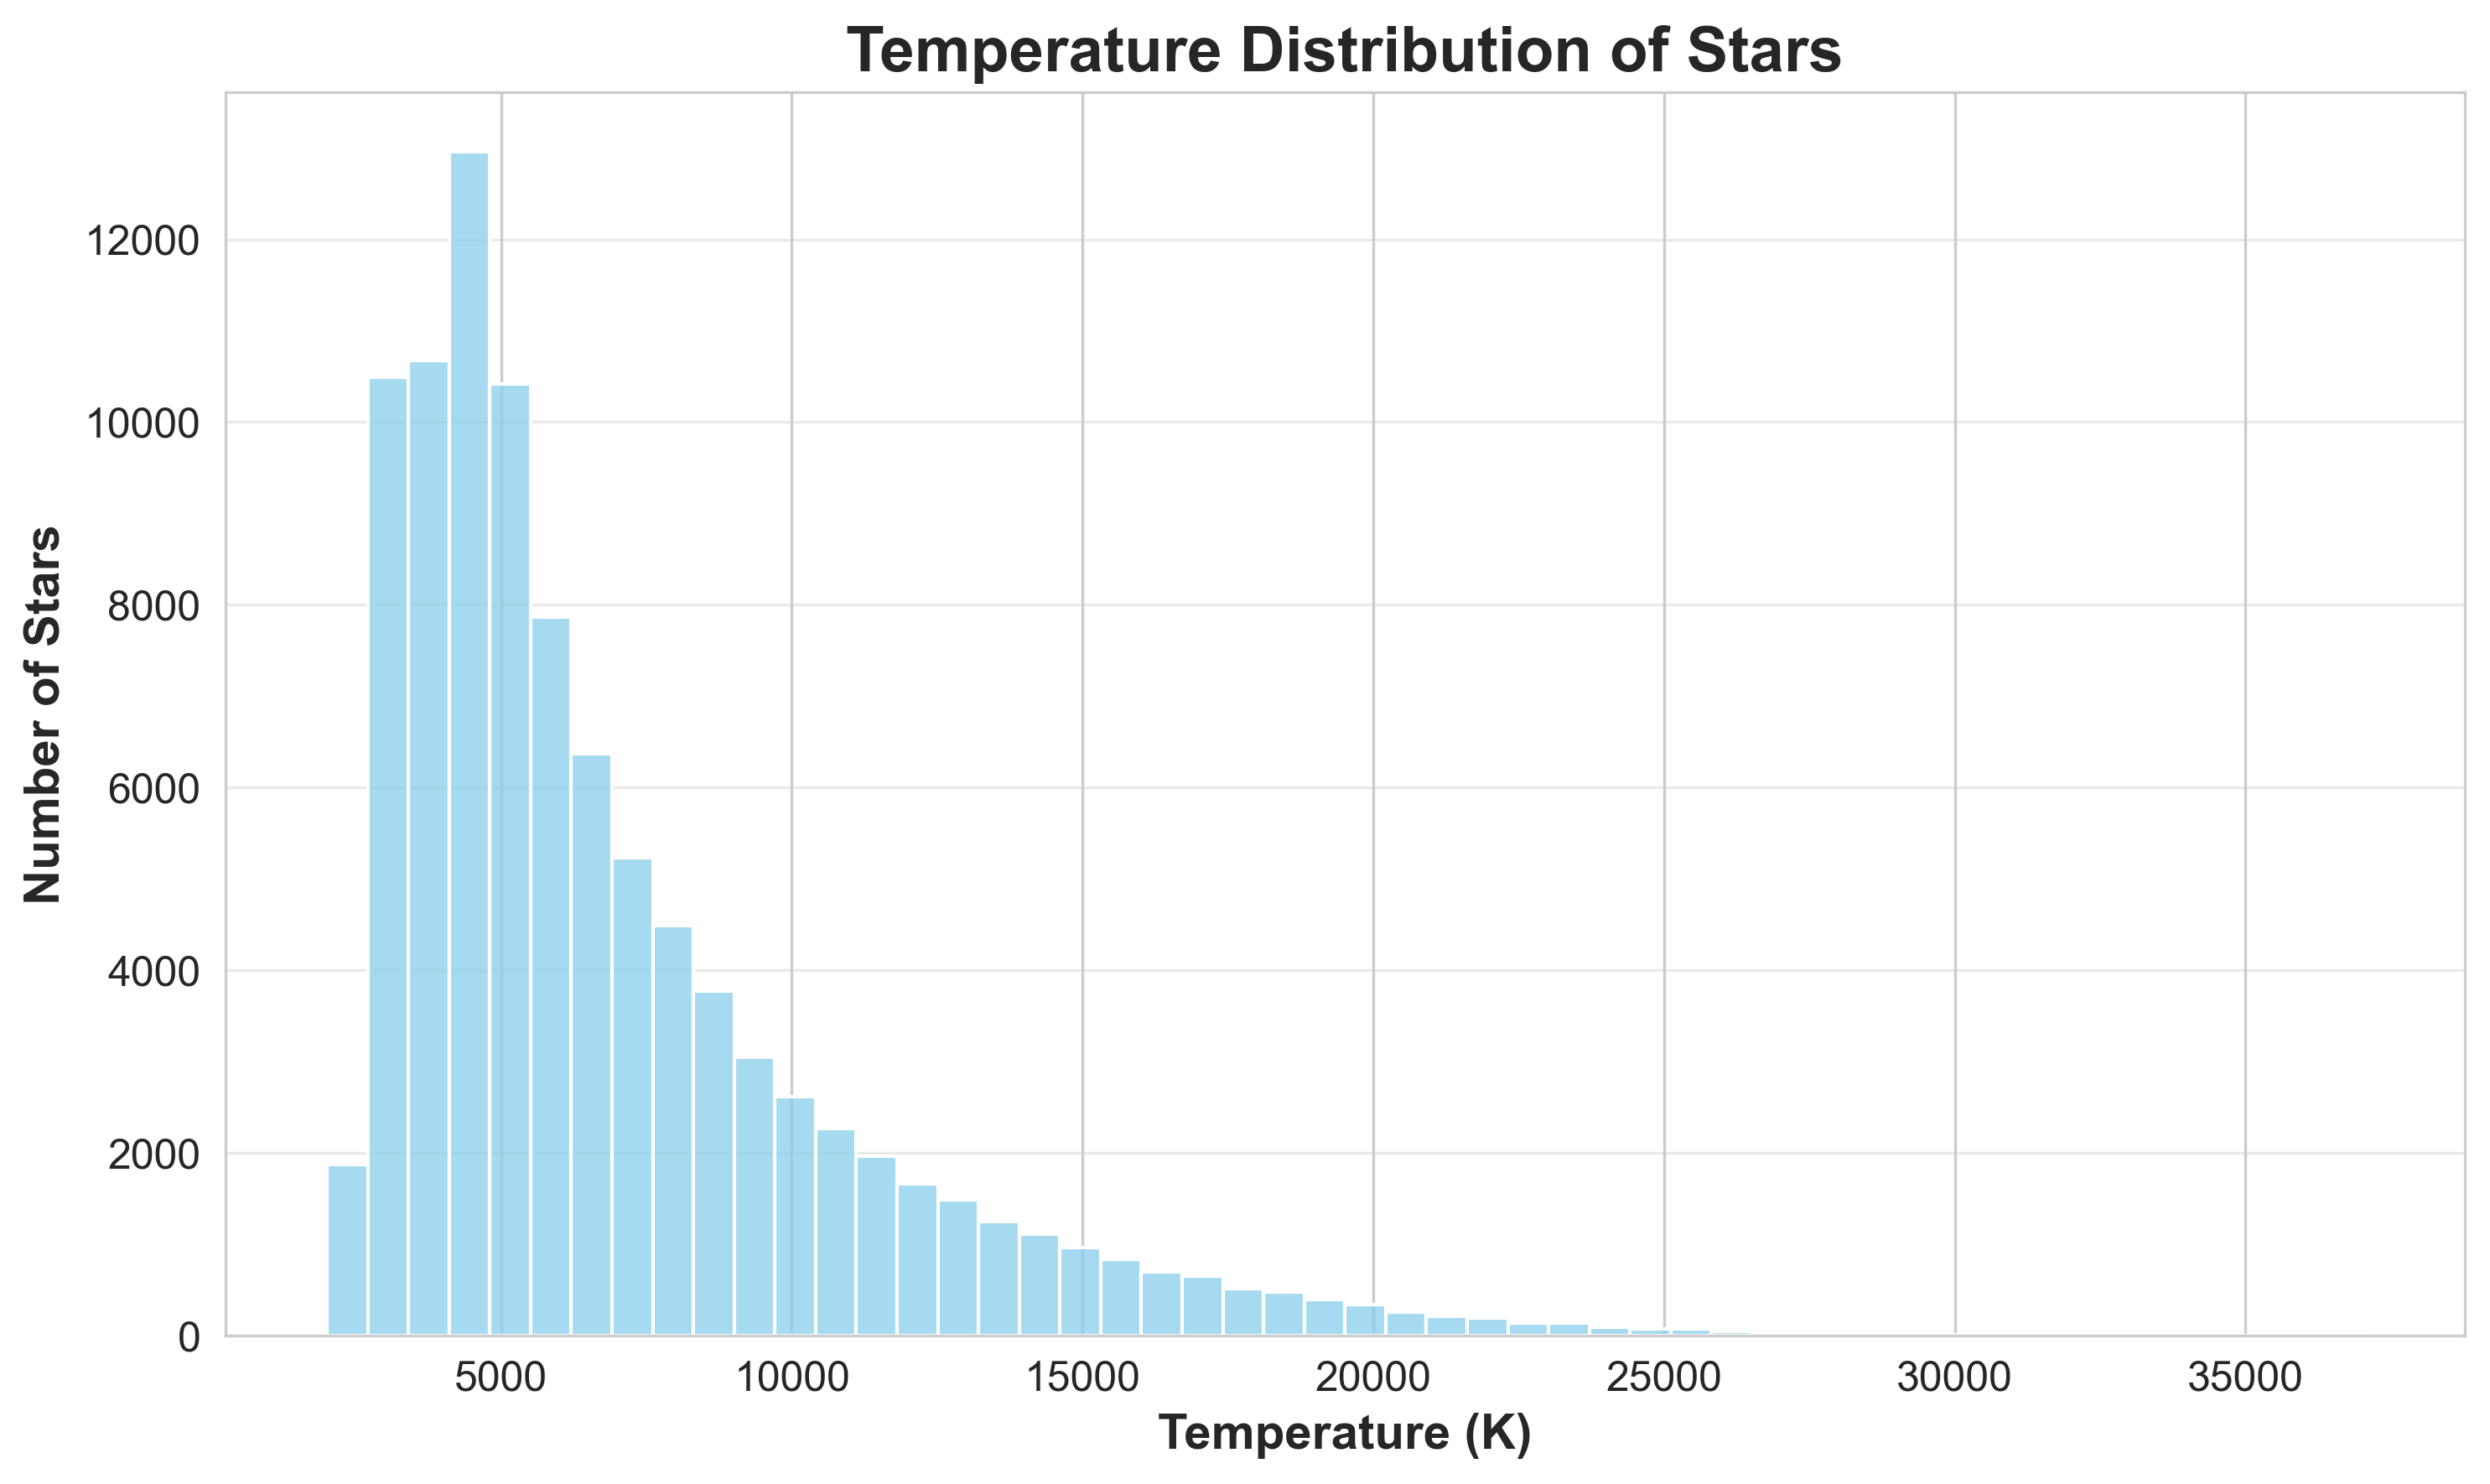

In [155]:
import seaborn as sns

# Create a histogram of the star temperatures
plt.figure(figsize=(10, 6), dpi=300)
sns.set_style("whitegrid")

# Plot the histogram with 50 bins
ax = sns.histplot(x=temperatures, bins=50, color="skyblue", kde=False)

# Set title and axis labels
ax.set_title("Temperature Distribution of Stars", fontsize=18, fontweight="bold")
ax.set_xlabel("Temperature (K)", fontsize=14, fontweight="bold")
ax.set_ylabel("Number of Stars", fontsize=14, fontweight="bold")

# Set tick parameters
ax.tick_params(axis="both", which="major", labelsize=12)

# Add grid lines and legend
ax.grid(axis="y", alpha=0.4)

# Save and show the plot
plt.tight_layout()
plt.savefig("star_temperatures.png")
plt.show()

In [150]:
import numpy as np

# Convert the temperatures list to a NumPy array
temperatures_array = np.array(temperatures)

# Calculate mean temperature uncertainty
mean_temp_uncertainty = np.mean(temp_errs_array)

# Print the average temperature and its uncertainty
print(f"Average Temperature: {mean_temp:.2f} ± {mean_temp_uncertainty:.2f} K")


# Calculate summary statistics
mean_temp = np.mean(temperatures_array)
median_temp = np.median(temperatures_array)
std_temp = np.std(temperatures_array)
min_temp = np.min(temperatures_array)
max_temp = np.max(temperatures_array)

# Print summary statistics
print("Temperature Distribution Summary Statistics:")
print(f"Median: {median_temp:.2f} K")
print(f"Standard Deviation: {std_temp:.2f} K")
print(f"Minimum: {min_temp:.2f} K")
print(f"Maximum: {max_temp:.2f} K")


Average Temperature: 6989.38 ± 92.06 K
Temperature Distribution Summary Statistics:
Median: 5626.56 K
Standard Deviation: 4128.84 K
Minimum: 2005.98 K
Maximum: 37020.03 K


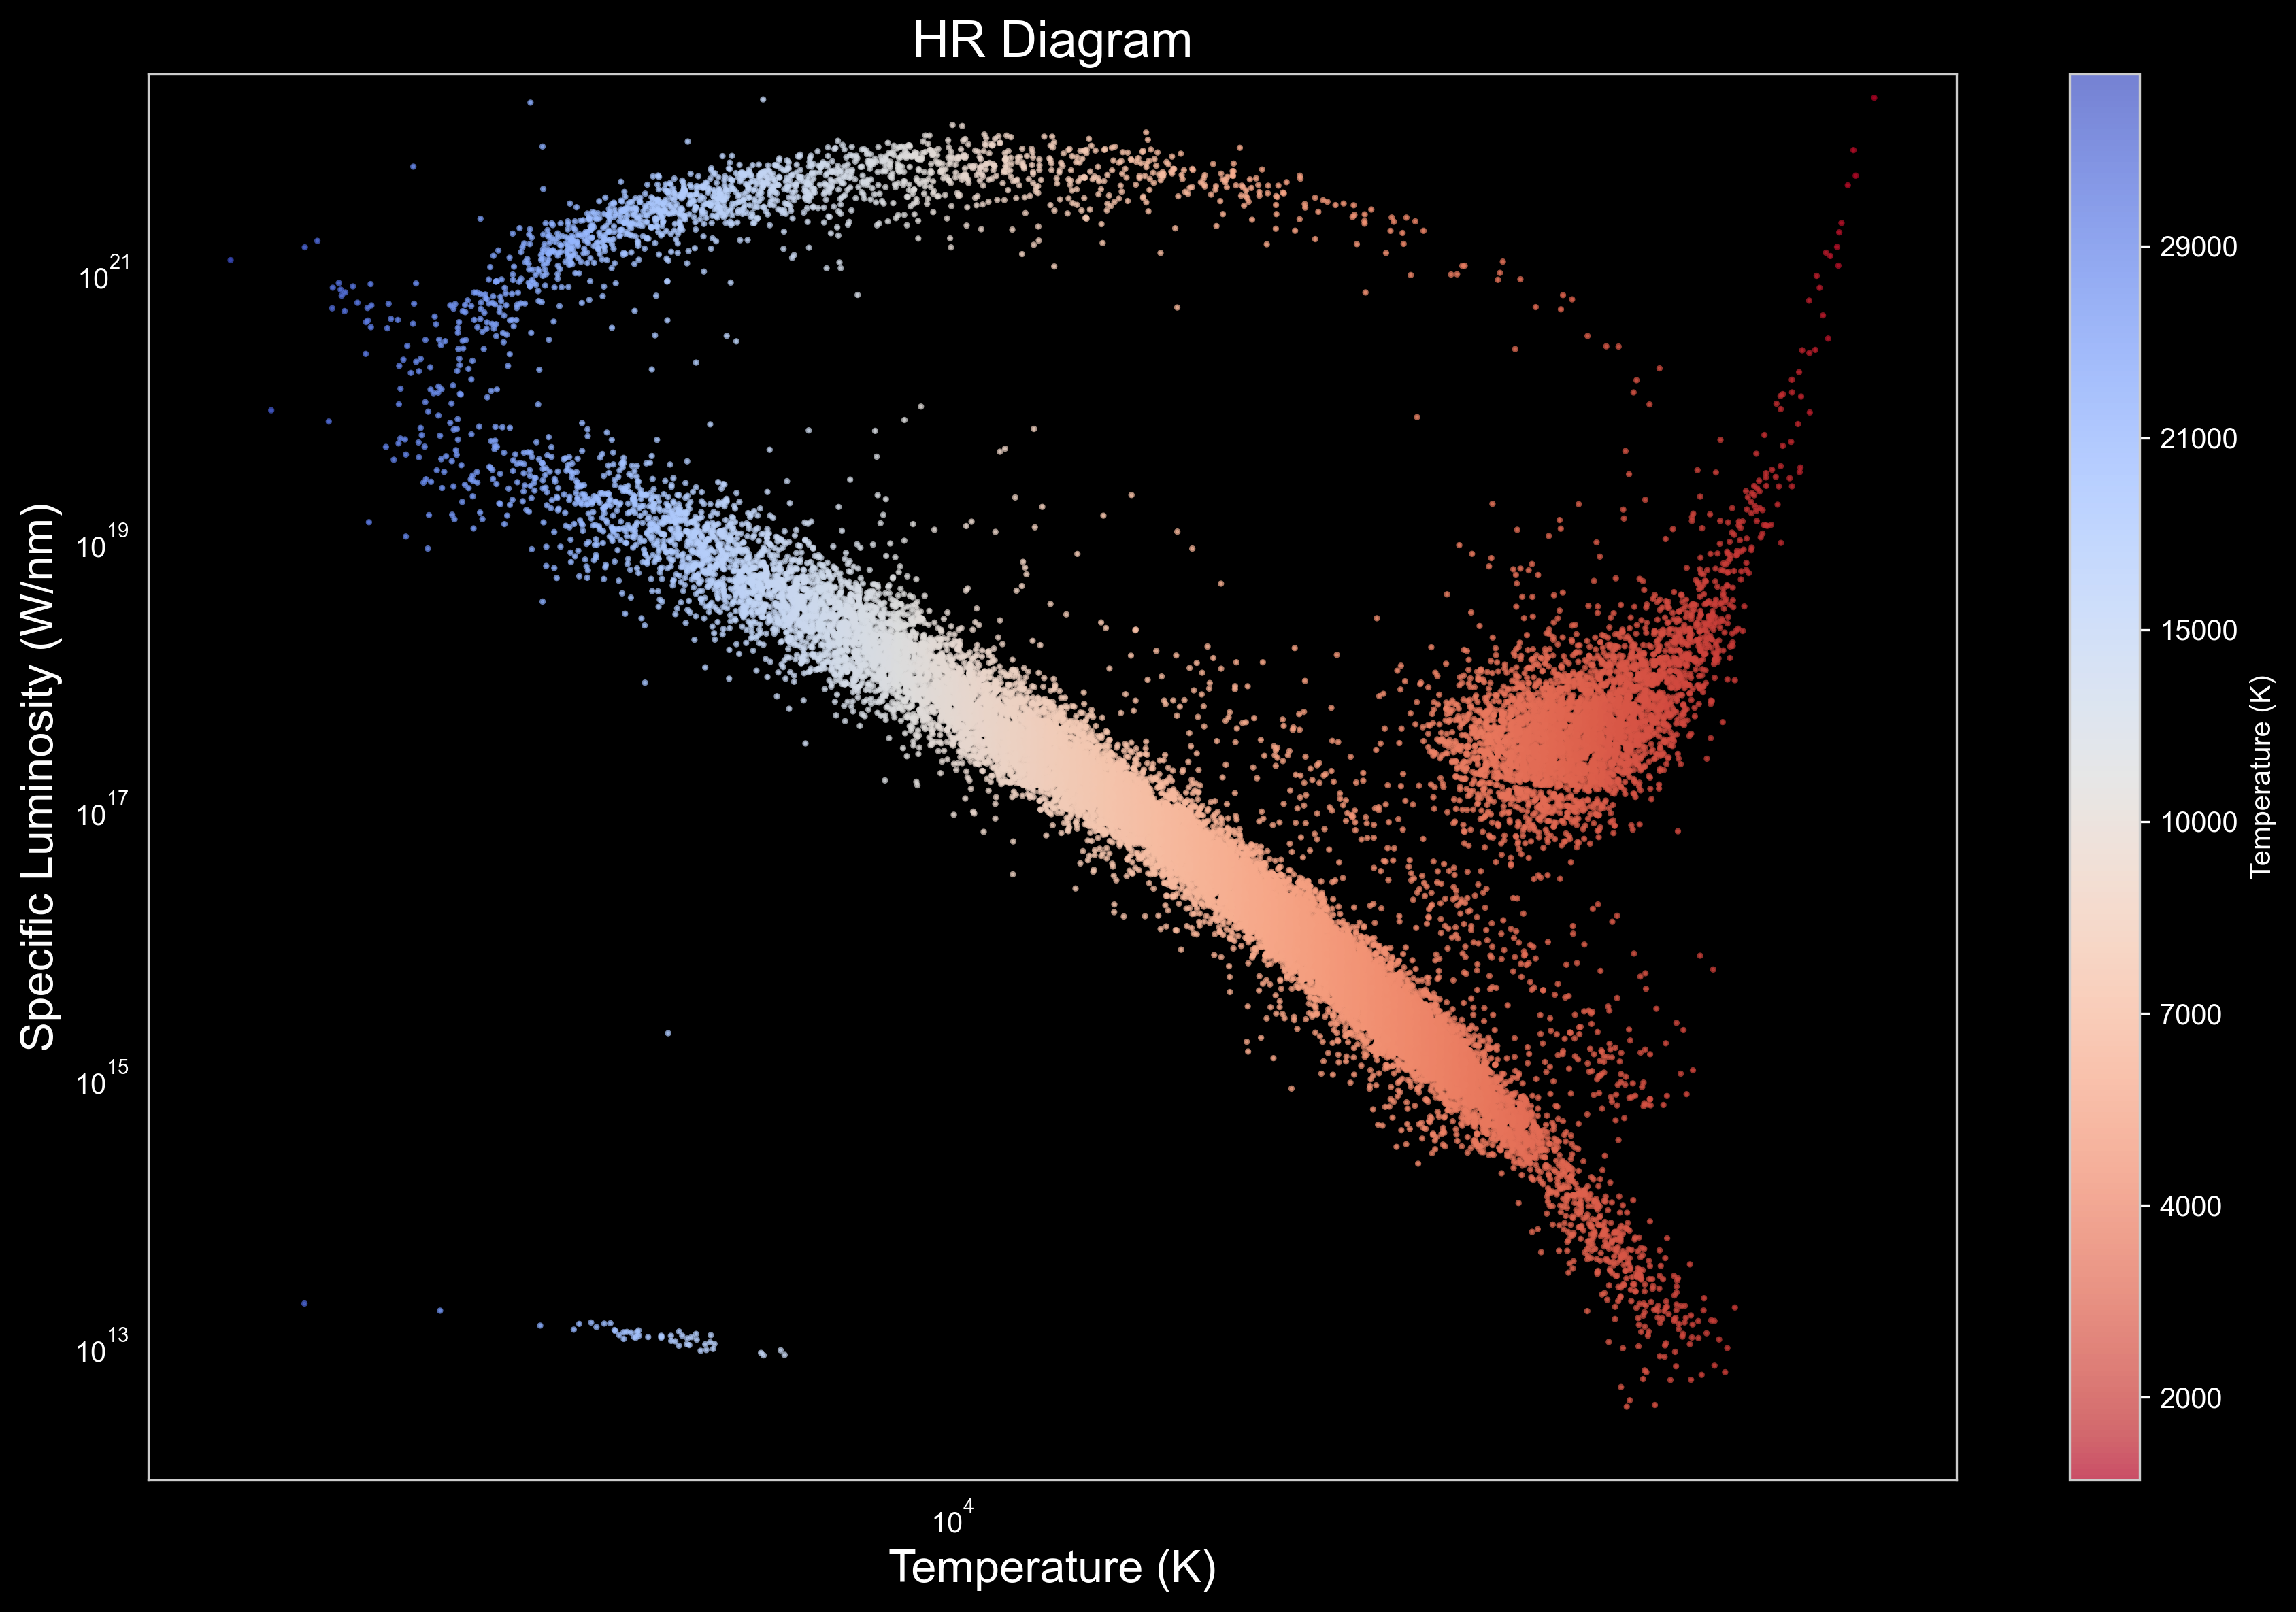

<Figure size 640x480 with 0 Axes>

In [158]:
import random
import matplotlib.cm as cm
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

def temp_formatter(x, pos):
    temp = round(x**4, -3)
    return "{:.0f}".format(temp)

# Define a custom colormap that goes from orange to blue
cmap_colors = cm.get_cmap('coolwarm_r')(np.linspace(0, 1, 256))
custom_cmap = ListedColormap(cmap_colors)

# Choose a random sample of 25000 stars
random_sample_size = 25000
random_indices = random.sample(range(len(valid_temperatures)), random_sample_size)
sampled_temperatures = [valid_temperatures[i] for i in random_indices]
sampled_luminosities = [valid_luminosities[i] for i in random_indices]

# Create a new array of temperatures with the same length as sampled_temperatures
# Apply power law transformation with power of 0.25
cmap_temperatures = [sampled_temperatures[i]**0.25 for i in range(len(sampled_temperatures))]

# Plot HR diagram with temperature colormap
fig, ax = plt.subplots(figsize=(12,8), dpi=300, facecolor='black')
sc = ax.scatter(sampled_temperatures, sampled_luminosities, s=1.5, c=cmap_temperatures, cmap=custom_cmap, alpha=0.7)

# Add colorbar with custom tick formatter
cbar = plt.colorbar(sc, format=FuncFormatter(temp_formatter))
cbar.set_label('Temperature (K)', color='white')
cbar.ax.yaxis.set_tick_params(color='white')
cbar.ax.tick_params(labelcolor='white')

# Add labels and scale
ax.invert_xaxis() # invert the x-axis
ax.set_xlabel('Temperature (K)', fontsize=16, color='white')
ax.set_ylabel('Specific Luminosity (W/nm)', fontsize=16, color='white')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('HR Diagram', fontsize=18, color='white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.tight_layout()
ax.set_ylim(1e12, 3e22)

# Set background color to black
ax.set_facecolor('black')

# Remove grid lines
ax.grid(False)

# Show plot
plt.show()

plt.savefig('hr_diagram.png', dpi=300)


  0%|                                                 | 0/96325 [00:00<?, ?it/s]

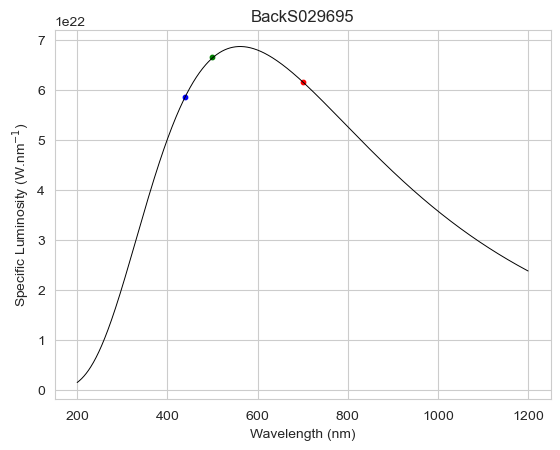

  0%|                                       | 1/96325 [00:00<5:01:16,  5.33it/s]

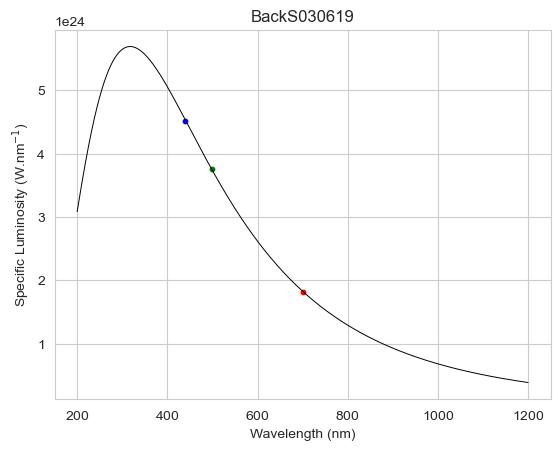

  0%|                                       | 2/96325 [00:00<4:20:29,  6.16it/s]

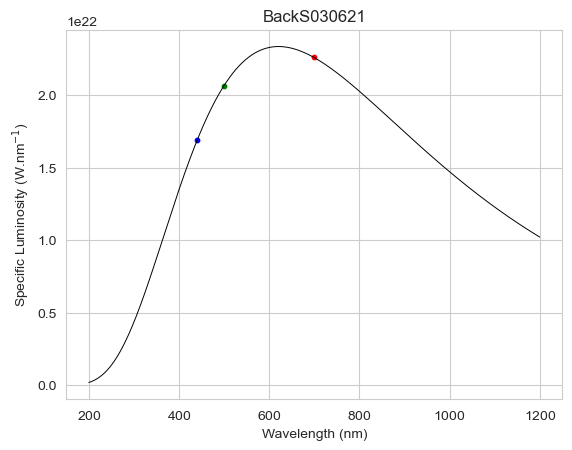

  0%|                                       | 3/96325 [00:00<6:28:47,  4.13it/s]

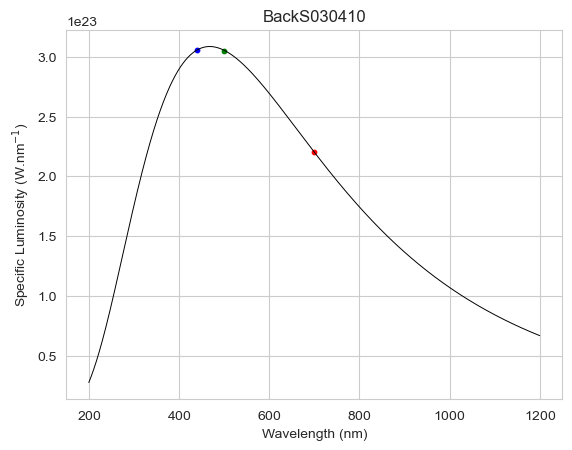

  0%|                                       | 4/96325 [00:00<5:15:26,  5.09it/s]

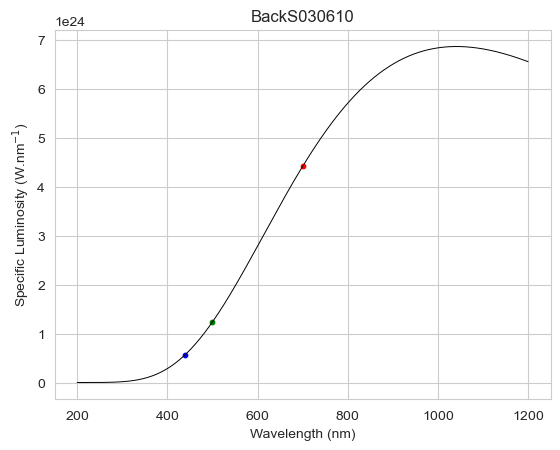

  0%|                                       | 5/96325 [00:00<4:36:50,  5.80it/s]

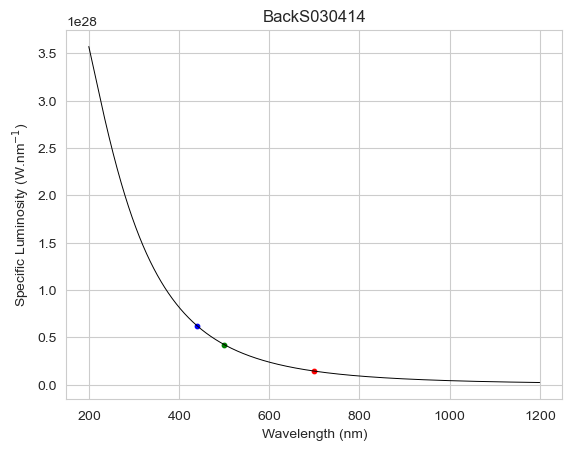

  0%|                                       | 6/96325 [00:01<4:12:46,  6.35it/s]

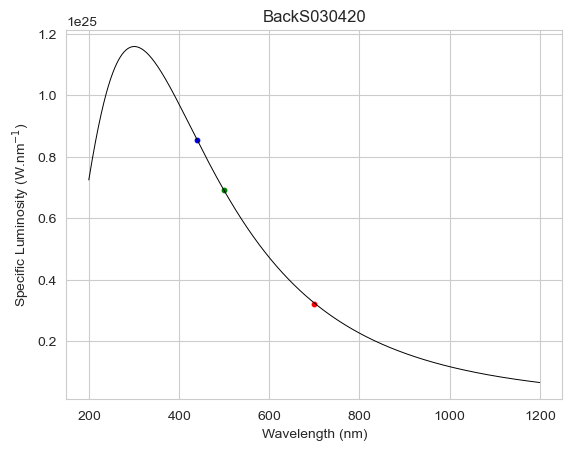

  0%|                                       | 7/96325 [00:01<3:53:10,  6.88it/s]

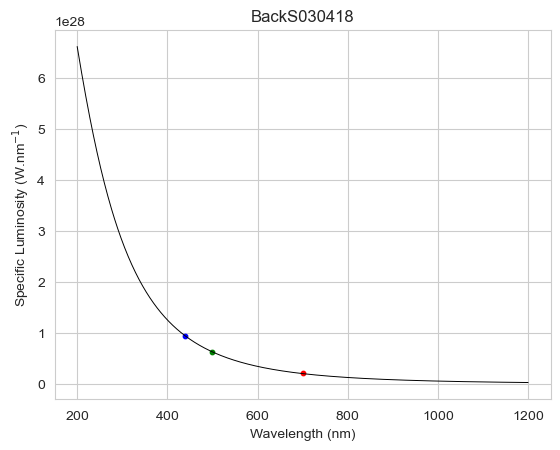

  0%|                                       | 8/96325 [00:01<3:43:21,  7.19it/s]

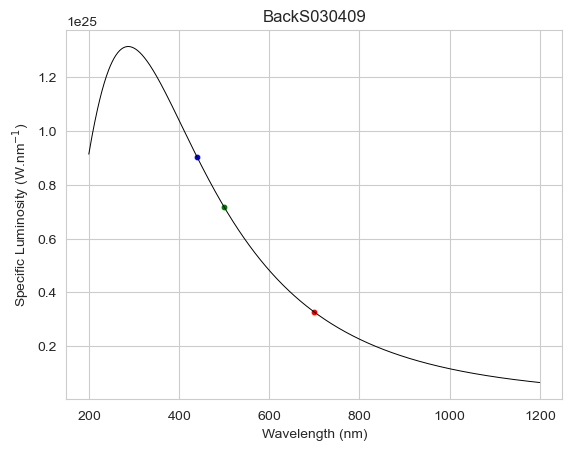

  0%|                                       | 9/96325 [00:01<4:00:13,  6.68it/s]

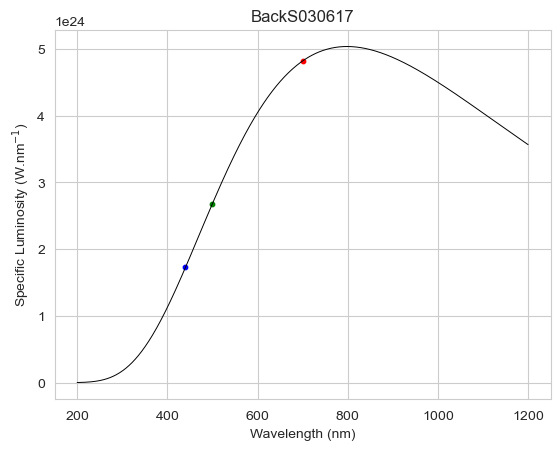

  0%|                                      | 10/96325 [00:01<3:47:08,  7.07it/s]/Users/kobibrown/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
  5%|█▋                                  | 4600/96325 [00:04<00:50, 1826.47it/s]/var/folders/kv/ny8sb_xj09b1r7l0mtvkgjlm0000gn/T/ipykernel_82500/2191319384.py:16: RuntimeWarning: overflow encountered in exp
  funct = 2 * h * c**2 / x**5 / (np.exp(h * c / (x * k * T)) - 1) * a
100%|███████████████████████████████████| 96325/96325 [00:53<00:00, 1810.79it/s]


KeyboardInterrupt: 

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
from tqdm import tqdm

# Load the data from the CSV file
star_data = pd.read_csv("/Users/kobibrown/Desktop/Distance_Ladder_Project/clustered_star_data_with_distances.csv")

# planck function
def planck_func(x, T, a):
    h = 6.626e-34  # Planck's constant in m^2 kg / s
    c = 3e8        # Speed of light in m/s
    k = 1.38e-23   # Boltzmann's constant in m^2 kg / s^2 K
    funct = 2 * h * c**2 / x**5 / (np.exp(h * c / (x * k * T)) - 1) * a
    return funct


# pull data
wavelengths = np.array([440e-9, 500e-9, 700e-9])  # Wavelengths for blue, green, and red bands
flux_cols = ["BlueF", "GreenF", "RedF"]
fluxes = star_data[flux_cols].values
parallax = star_data["Parallax"].values

# simulate planck function
temperatures = []
temp_errs = [] # stop temp uncertainty
luminosities = []
names = []
for i, flux_row in tqdm(enumerate(fluxes), total=len(fluxes)):
    # Use the calculated distance if it is over 200 parsecs, otherwise use parallax
    par = parallax[i]
    dist_parallax = 1 / par if par > 0.005 else np.nan
    dist_estimated = star_data.iloc[i]["Distance"]

    dist = dist_parallax if dist_parallax < 200 else dist_estimated

    multiplier = (dist * 3.086e16)**2  # approx luminosity
    specific_luminosity = flux_row * multiplier    # Specific Luminosity for each band
    try:
        star_props, cov = curve_fit(planck_func, wavelengths, specific_luminosity, p0=[10000, 1e10])
        star_temp, mult = star_props
        temp_err = np.sqrt(np.diag(cov))[0] # find the uncertainty
        if star_temp > 2000 and star_temp < 150000:  # define realistic values
            temperatures.append(star_temp)
            temp_errs.append(temp_err)
            luminosities.append(np.sum(specific_luminosity))
            names.append(star_data.iloc[i]["Name"])
            if len(temperatures) <= 10:
                x = np.linspace(200e-9, 1200e-9, 1000)
                planck = planck_func(x, *star_props)
                plt.plot(x * 1e9, planck, c="k", linewidth=0.7)
                for j, flux in enumerate(flux_row):
                    plt.scatter(wavelengths[j] * 1e9, flux * multiplier, c=["b", "g", "r"][j], s=10)
                plt.xlabel("Wavelength (nm)")
                plt.ylabel("Specific Luminosity (W.nm$^{-1}$)")
                plt.ticklabel_format(axis="x", style="scientific", useMathText=True)
                plt.title(names[-1])
                plt.show()
    except RuntimeError:
        pass

# Convert the temperatures and luminosities to NumPy arrays
temperatures_array = np.array(temperatures)
temp_errs_array = np.array(temp_errs)
luminosities_array = np.array(luminosities)

# Add the temperature, temperature uncertainty, and luminosity columns to the star data
star_data['Temperature'] = np.nan
star_data['Temperature_Uncertainty'] = np.nan
star_data['Luminosity'] = np.nan

# Fill in the temperature, temperature uncertainty, and luminosity values for each star
for i, name in enumerate(names):
    star_data.loc[star_data['Name'] == name, 'Temperature'] = temperatures_array[i]
    star_data.loc[star_data['Name'] == name, 'Temperature_Uncertainty'] = temp_errs_array[i]
    star_data.loc[star_data['Name'] == name, 'Luminosity'] = luminosities_array[i]

# Save the updated star data to a new CSV file
star_data.to_csv('/Users/kobibrown/Desktop/Distance_Ladder_Project/star_data_with_temp_lum_and_dist.csv', index=False)

